In [ ]:
# ! ls ../../segmentation/bin2cell/bin2cell_output_he0005_gex005/IMMUNEX001
! ls ../../segmentation/bin2cell/

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX001"

adata = sc.read(f"../../segmentation/bin2cell/bin2cell_output_he0.01_gex0.05/{sample_id}/adata_processed.h5ad")
adata.raw = adata
adata.uns['sample_id'] = sample_id

fraction = 0.15
n_cells = adata.n_obs
n_sample = int(n_cells * fraction)

# Sample indices
np.random.seed(42)  # For reproducibility
sampled_indices = np.random.choice(n_cells, size=n_sample, replace=False)

# Subset the AnnData
adata_sampled = adata[sampled_indices].copy()

adata_sampled.shape

(1441966, 18322)

In [2]:
# Load the metadata
metadata = pd.read_csv("~/rawdata/IMMUNEX/data/VisiumHD_18_2024_NSCLC.csv")
display(metadata.sample())

metadata_sample = metadata[metadata['Sample_code'] == sample_id]
adata_sampled.uns["sample_metadata"] = metadata_sample.iloc[0].to_dict()

display(adata_sampled.obs.sample()) # Display the first few rows of the observation data (cell metadata)

print(adata_sampled.shape)

,Manip_Visium,DV200,HE_image_name,Cytasimage_path,TLS_status,area,slide,Average_fragment_size,Concentratio_pg_per_µL,Concentration finale (ng/µL),Final_concentration_nM,Dual _Index,Volume_available_µL,Volume_send_µL,Sample_code,Position_on_the_plaque,Sea_Dual_Index_TS_Set_A
14,NJ309,39,IMMUNEX015_Visium_HE_x40_z0.tif,assay_CAVG10047_NJ309_22janv2025_H1-7BFQC6K_17...,Low,D1,H1-7BFQC6K,257,182.2,9.1,53.7,H5,around_24,22,IMMUNEX015,G2,"SI-TS-H5,CCCGCTTGAA,GCCCAAGGTA,TACCTTGGGC"


,in_tissue,array_row,array_col,n_counts,destripe_factor,n_counts_adjusted,labels_he,labels_he_expanded,labels_gex,labels_joint,labels_joint_source
s_002um_01274_00733-1,1,1274,733,11.0,0.515439,17.009476,186780,186780,0,186780,primary


(1441966, 18322)


## Seg. sources

In [5]:
msk = adata_sampled.obs['labels_he'] != 0
adata_sampled = adata_sampled[msk]
adata_sampled

View of AnnData object with n_obs × n_vars = 385298 × 18322
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial', 'sample_id', 'sample_metadata'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [8]:
adata_sampled.obs['cell_id'] = adata_sampled.obs['labels_joint'].astype(str)
adata_cells = adata_sampled[adata_sampled.obs['labels_joint'] > 0].copy()
adata_cells.var['mt'] = adata_cells.var_names.str.upper().str.startswith('MT-')

# Use CSR for efficient row slicing
X = adata_cells.X.tocsr()
cell_ids = adata_cells.obs['cell_id'].values
print('Analysing')

# Map cell_id to integer index
unique_ids, inverse_idx = np.unique(cell_ids, return_inverse=True)
n_cells = len(unique_ids)
n_genes = X.shape[1]
print('Analysing')

# Initialize empty matrix to store the result
# Result will be dense at the end, but small: (n_cells x n_genes)
result = np.zeros((n_cells, n_genes))
print('Analysing')

# Efficient sparse row-by-row summing
for i in tqdm(range(X.shape[0])):
    result[inverse_idx[i]] += X[i].toarray()[0]

# Convert to DataFrame
grouped_expr = pd.DataFrame(result, index=unique_ids, columns=adata_cells.var_names)

adata_cells = AnnData(X=sp.csr_matrix(grouped_expr.values))
adata_cells.obs_names = grouped_expr.index
adata_cells.var_names = grouped_expr.columns # Gene Names



Analysing
Analysing
Analysing


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385298/385298 [00:36<00:00, 10684.73it/s]


In [11]:

# and 'cell_id' is the grouping key used to generate grouped_expr
# 1. Get a mapping from cell_id → average spatial position
cell_coords = adata_sampled.obs[['cell_id']].copy()
cell_coords['x'] = adata_sampled.obsm['spatial'][:, 0]
cell_coords['y'] = adata_sampled.obsm['spatial'][:, 1]

# 2. Average spatial position per cell
mean_coords = cell_coords.groupby('cell_id')[['x', 'y']].mean()

# 3. Match to your grouped_expr.index (cell IDs)
mean_coords = mean_coords.loc[grouped_expr.index]

# 4. Assign to obsm
adata_cells.obsm['spatial'] = mean_coords.values

# Copy the spatial dictionary to cdata
library_id = list(adata_sampled.uns['spatial'].keys())[0]
adata_cells.uns['spatial'] = {
    library_id: adata_sampled.uns['spatial'][library_id]
}


## Get metadata from bins

In [13]:
# Step 1: Copy gene metadata (var) for the grouped expression matrix
adata_cells.var = adata_sampled.var.loc[grouped_expr.columns].copy()
adata_cells.var_names_make_unique()

# Step 2: Aggregate metadata per reconstructed cell
meta = adata_sampled.obs.groupby('cell_id').agg({
    'n_counts': 'sum',
})
# - Number of bins per cell (count of occurrences)
meta['n_bins'] = adata_sampled.obs['cell_id'].value_counts()
meta.index.name = 'cell_id'

# Step 3: Reorder metadata to match cell ordering in grouped_expr
meta = meta.loc[grouped_expr.index]

# Step 4: Assign aggregated metadata as the new obs for reconstructed cells
adata_cells.obs = meta

# Step 5: Copy over select entries from uns
for k in ['sample_id', 'sample_metadata', 'bin2cell']:
    if k in adata.uns:
        adata_cells.uns[k] = adata.uns[k]

# Step 6: Copy full spatial metadata
adata_cells.uns['spatial'] = adata.uns['spatial']

# Done
adata_cells


AnnData object with n_obs × n_vars = 204308 × 18322
    obs: 'n_counts', 'n_bins'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'sample_id', 'bin2cell'
    obsm: 'spatial'

## Croped vizualisation

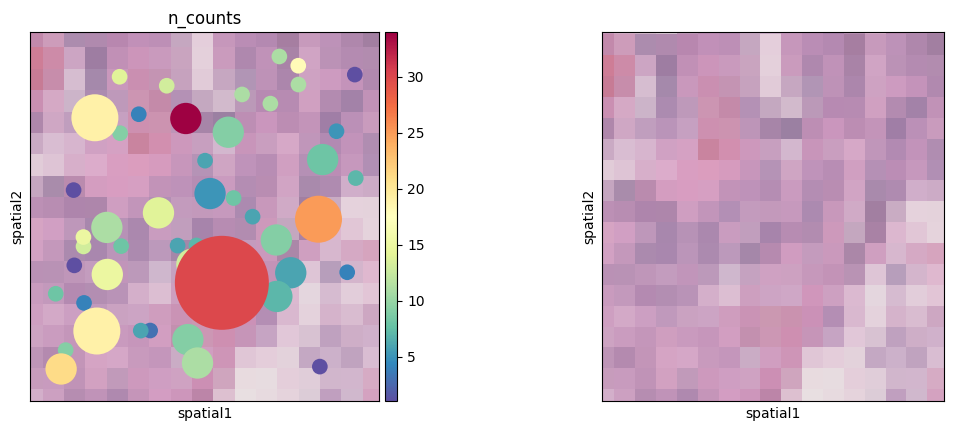

In [14]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

crop_axis_fraction = 0.01  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


In [ ]:
# # plot each cell with a different color
# adata_cropped.obs['labels_joint'] = adata_cropped.obs.index.astype('int')
# # adata_cropped.obs['labels_joint'] = adata_cropped.obs['labels_joint'].astype('category')

# sc.pl.spatial(
#     adata_cropped,
#     color='labels_joint', 
#     size=1,
#     cmap='Spectral',
#     alpha_img=.7,
#     spot_size=22,
#     show=True,
#     # cmap='Set2'
# )

# plt.show()

In [ ]:
# adata_cropped.write(f'../results/intermediate/{sample_id}/cropped_{str(crop_axis_fraction)}_for_spatial_clustering.h5ad')

In [ ]:
# file_path = f'../results/intermediate/{sample_id}/cropped_{str(crop_axis_fraction)}_for_spatial_clustering.h5ad'
# adata_cropped = sc.read_h5ad(file_path)
# adata_cropped


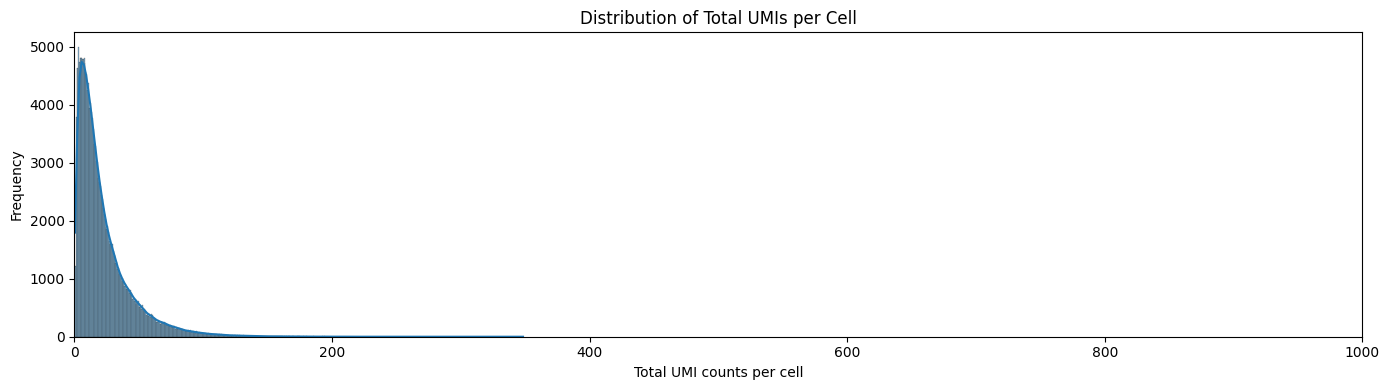

In [15]:
#Visualize the UMI (total counts)
#distribution per cell and the expression distributions of specific marker genes

adata_cells.obs['total_counts'] = np.array(adata_cells.X.sum(axis=1)).flatten()
adata_cells.obs['n_genes_by_counts'] = np.array((adata_cells.X > 0).sum(axis=1)).flatten()
adata_cells.obs

plt.figure(figsize=(14, 4))
sns.histplot(adata_cells.obs['total_counts'], bins=555, kde=True)
plt.xlabel("Total UMI counts per cell")
plt.ylabel("Frequency")
plt.title("Distribution of Total UMIs per Cell")
plt.xlim(0, 1000)  # limit x-axis
plt.tight_layout()
plt.show()



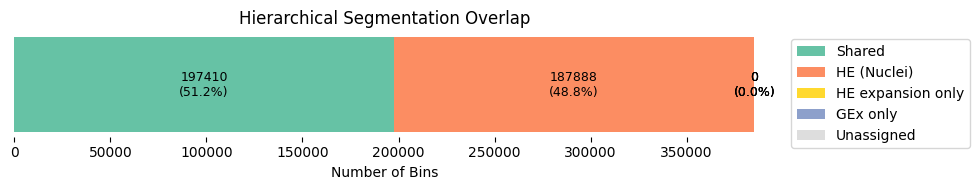

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Boolean masks from adata
is_he = adata_sampled.obs['labels_he'] != 0
is_he_exp = adata_sampled.obs['labels_he_expanded'] != 0
is_gex = adata_sampled.obs['labels_gex'] != 0

# Hierarchical categorization
conditions = {
    "Shared": is_he_exp & is_gex,
    "HE (Nuclei) ": is_he & ~is_gex,
    "HE expansion only": is_he_exp & ~is_gex & ~is_he,
    "GEx only": is_gex & ~is_he_exp,
    "Unassigned": ~is_he_exp & ~is_gex
}

# Count bins in each category
counts = {k: v.sum() for k, v in conditions.items()}

# Create DataFrame
df = pd.DataFrame(list(counts.items()), columns=["Category", "Count"])
df["Percentage"] = df["Count"] / df["Count"].sum() * 100

# Ensure specific order
df["Category"] = pd.Categorical(df["Category"], categories=[
    "Shared", "HE (Nuclei) ", "HE expansion only", "GEx only", "Unassigned"
], ordered=True)
df = df.sort_values("Category")

# Define custom colors
colors = {
    "Shared": "#66c2a5",
    "HE (Nuclei) ": "#fc8d62",
    "HE expansion only": "#ffd92f",
    "GEx only": "#8da0cb",
    "Unassigned": "#dddddd"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
left = 0
for _, row in df.iterrows():
    ax.barh(y=0, width=row["Count"], left=left,
            color=colors[row["Category"]], label=row["Category"])
    ax.text(left + row["Count"]/2, 0,
            f"{int(row['Count'])}\n({row['Percentage']:.1f}%)",
            ha="center", va="center", fontsize=9, color="black")
    left += row["Count"]

ax.set_yticks([])
ax.set_xlabel("Number of Bins")
ax.set_title("Hierarchical Segmentation Overlap")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [23]:
crop_axis_fraction

0.01

Ploting nuclei #1


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f97bc96fe80>>
Traceback (most recent call last):
  File "/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
IOStream.flush timed out


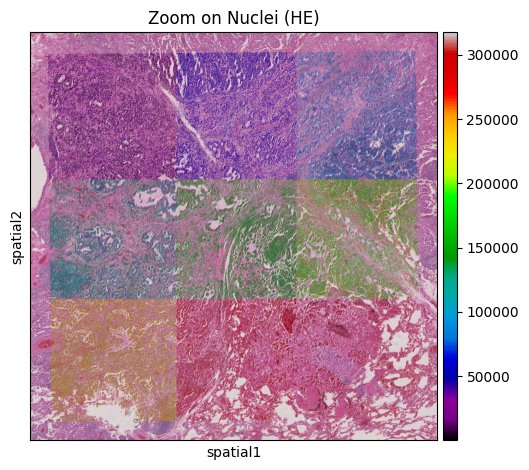

In [24]:

mask = adata.obs['labels_he'] != 0
adata_nuc = adata[mask].copy()

# # ---- Plot 1: full image with crop box ----
# fig, ax = plt.subplots(figsize=(6, 6))
# sc.pl.spatial(
#     adata_filtered,
#     ax=ax,
#     color=None,
#     show=False,
#     alpha_img=0.8,
#     size=1
# )
# # Add rectangle showing crop area
# rect = Rectangle(
#     (x0, y0),
#     x1 - x0,
#     y1 - y0,
#     linewidth=2,
#     edgecolor='red',
#     facecolor='none'
# )
# ax.add_patch(rect)
# ax.set_title("Full image with crop area")
# plt.tight_layout()

# plt.tight_layout()
# output_path = os.path.join(sample_output_dir, f"{sample_id}_crop pos.png")
# fig = plt.gcf()  # Get the current figure
# fig.savefig(output_path, dpi=300)

# print('Crop position ploted')


crop_axis_fraction = 0.002  # Fraction of the tissue area to crop around the center

# Get spatial coordinates
spatial_coords = adata_sampled.obsm['spatial'].copy()

# Compute tissue bounds and center
x_min, x_max = spatial_coords[:, 0].min(), spatial_coords[:, 0].max()
y_min, y_max = spatial_coords[:, 1].min(), spatial_coords[:, 1].max()
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds
dx = (x_max - x_min) * crop_axis_fraction / 2
dy = (y_max - y_min) * crop_axis_fraction / 2
x0, x1 = center_x - dx, center_x + dx
y0, y1 = center_y - dy, center_y + dy

# Subset AnnData to cropped region
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped_bins = adata_sampled[within_crop, :].copy()

# # ---- Plot 1: full image with crop box ----
# fig, ax = plt.subplots(figsize=(6, 6))
# sc.pl.spatial(
#     adata_filtered,
#     ax=ax,
#     color=None,
#     show=False,
#     alpha_img=0.8,
#     size=1
# )
# # Add rectangle showing crop area
# rect = Rectangle(
#     (x0, y0),
#     x1 - x0,
#     y1 - y0,
#     linewidth=2,
#     edgecolor='red',
#     facecolor='none'
# )
# ax.add_patch(rect)
# ax.set_title("Full image with crop area")
# plt.tight_layout()

# plt.tight_layout()
# output_path = os.path.join(sample_output_dir, f"{sample_id}_crop pos.png")
# fig = plt.gcf()  # Get the current figure
# fig.savefig(output_path, dpi=300)

# print('Crop position ploted')

print('Ploting nuclei #1')
# ---- Plot 2: cropped region with nuclei labels ----
sc.pl.spatial(
    adata_nuc,
    color=['labels_he'],
    size=1,
    cmap='nipy_spectral',
    alpha_img=0.9,
    show=False,
    title="Zoom on Nuclei (HE)"
)
plt.tight_layout()


## Full image vizualisation

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define conditions
conditions = {
    "Shared": is_he_exp & is_gex,
    "HE (no expanded)": is_he & ~is_gex,
    "HE expansion only": is_he_exp & ~is_gex & ~is_he,
    "GEx only": is_gex & ~is_he_exp,
    "Unassigned": ~is_he_exp & ~is_gex
}

# Assign Segmentation_Category to adata
segmentation_category = pd.Series("Unassigned", index=adata_filtered.obs_names)
for label, mask in conditions.items():
    segmentation_category[mask] = label
adata_filtered.obs["Segmentation_Category"] = segmentation_category

# Define consistent category order and color palette
category_order = ["Shared", "HE (no expanded)", "HE expansion only", "GEx only", "Unassigned"]
category_colors = {
    "Shared": "red",
    "HE (no expanded)": "lime",
    "HE expansion only": "darkgreen",
    "GEx only": "blue",
    "Unassigned": "white"
}

# Extract coordinates and segmentation category
coords = adata_filtered.obsm["spatial"]
categories = adata_filtered.obs["Segmentation_Category"]

# Build dataframe for plotting
plot_df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "Category": categories
})

# Plot 1: Full Slide
plt.figure(figsize=(22, 22), dpi=100)
sns.scatterplot(data=plot_df, x="x", y="y", hue="Category", palette=category_colors, s=3, linewidth=0, alpha=0.9)
plt.title("Segmentation Categories - Full Slide")
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
plt.tight_layout()
plt.show()


NameError: name 'adata_filtered' is not defined

In [ ]:

sizes = adata_cells.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cells,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)

# QC and Normalization with BANKSY

In [ ]:
import sys
sys.path.append("/opt/Banksy_py")
import banksy as banksy
import time; import random

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
from banksy_utils.load_data import load_adata, display_adata
from banksy_utils.filter_utils import filter_cells
from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

import scipy.sparse
if not scipy.sparse.issparse(adata_cells.X):
    print('converting to sparse')
    adata_cells.X = scipy.sparse.csr_matrix(adata_cells.X)
    # adata.raw = adata.X
display_adata(adata_cells)


/opt/Banksy_py/banksy/cluster_methods.py:18: UserWarning: 
No rpy2 installed. BANKSY will run, but mclust will not work.
Note: you can still use the default leiden option for clustering.
Install rpy2 and R in your conda environment if you want to use mclust for clustering.

  warnings.warn(warn_str)


In [ ]:
# QC
adata_cells.var_names_make_unique()
adata_cells.var["mt"] = adata_cells.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata_cells, 
                           qc_vars=["mt"], 
                           log1p=True, 
                           inplace=True)

# bin options for fomratting histograms
# Here, we set 'auto' for 1st figure, 80 bins for 2nd figure. and so on
hist_bin_options = ['auto', 50, 80, 100]

plot_qc_hist(adata_cells, 
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
         bin_options = hist_bin_options)

In [ ]:
# initial filter of cells by their cell counts, MT count and gene counts
adata_filtred = adata_cells.copy()

adata_filtred = filter_cells(adata_filtred, 
             min_count=10, 
             max_count=1500, 
             MT_filter=20, 
             gene_filter=3)

plot_qc_hist(adata_filtred,
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
        bin_options = hist_bin_options)


{'fig_size': (8, 8), 's': 1, 'c1': 'red', 'c2': 'slateblue', 'label1': 'Original adata', 'label2': 'Filtered adata', 'add_circle': False, 'puck_center': (3330, 3180), 'puck_radius': 2550, 'alpha': 0.3}


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


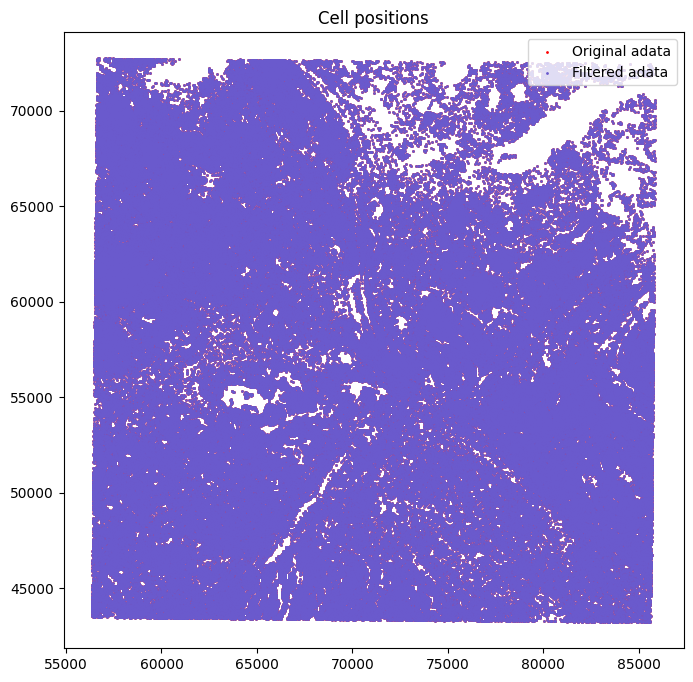

In [81]:
# Convert spatial coordinates to obs columns
adata_filtred.obs['spatial_0'] = adata_filtred.obsm['spatial'][:, 0]
adata_filtred.obs['spatial_1'] = adata_filtred.obsm['spatial'][:, 1]

# Call the plotting function with updated coord_keys
plot_cell_positions(
    adata=adata_filtred,
    raw_x=adata_filtred.obsm['spatial'][:, 0],
    raw_y=adata_filtred.obsm['spatial'][:, 1],
    coord_keys=('spatial_0', 'spatial_1'),
    s=1,
    alpha=.3,
    label1="Original adata",
    label2="Filtered adata"
)
plt.legend()
plt.show()

51600


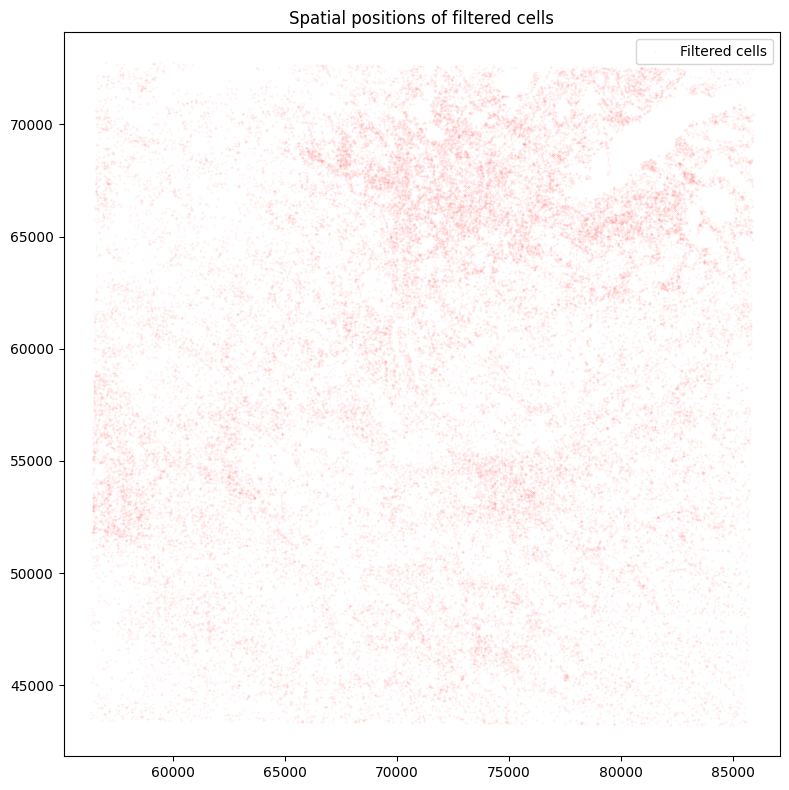

In [90]:
import matplotlib.pyplot as plt

# 1. Get the original and filtered indices
original_indices = set(adata_cells.obs_names)
filtered_indices = set(adata_filtred.obs_names)

# 2. Identify remaining cells (i.e., filtered in)
filtered_out_indices = original_indices - filtered_indices
print(len(filtered_out_indices))

adata_out = adata_cells[list(filtered_out_indices)].copy()

# 4. Add spatial coords to .obs
adata_out.obs['spatial_0'] = adata_out.obsm['spatial'][:, 0]
adata_out.obs['spatial_1'] = adata_out.obsm['spatial'][:, 1]

# 5. Plot
plt.figure(figsize=(8, 8))
plt.scatter(
    adata_out.obs['spatial_0'],
    adata_out.obs['spatial_1'],
    s=0.1,
    alpha=.1,
    c='red',
    label='Filtered cells'
)
plt.axis("equal")
plt.title("Spatial positions of filtered cells")
plt.legend()
plt.tight_layout()
plt.show()


In [91]:
adata_cells

AnnData object with n_obs × n_vars = 271347 × 18322
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

<Axes: title={'center': 'total_counts_mt'}, xlabel='spatial1', ylabel='spatial2'>

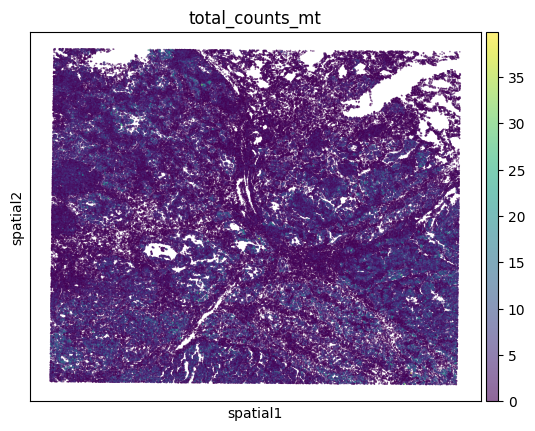

In [92]:
sc.pl.embedding(
    adata_cells,
    basis="spatial",
    color=f'total_counts_mt',
    size=5,
    alpha=0.6,
    show=False
)

In [93]:
#Identify highly variable genes — modify filter_hvg to skip log1p inside
adata_normalized = adata_filtred.copy()
adata_normalized = normalize_total(adata_normalized)
sc.pp.log1p(adata_normalized)
adata_normalized.shape

--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 108.43403165837171, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 34.44481694654592, Min: 0.0



(219747, 16489)

In [94]:
sc.pp.highly_variable_genes(adata_normalized, n_top_genes=2000, flavor='seurat')

nsclc_marker_genes = sorted(list(set([
    # T cells
    'CD3D', 'CD3E', 'CD3G', 'CD2', 'CD7', 'TRAC', 'JUNB', 'S100A4', 'CD52', 'PFN1P1',
    'CD81', 'EEF1B2P3', 'CXCR4', 'CREM', 'IL32', 'TGIF1',

    # CD4+ T cells
    'CD4', 'IL7R', 'CCR7', 'SELL', 'FOXP3', 'CTLA4', 'TIGIT',

    # CD8+ T cells
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'LAG3', 'PDCD1',

    # Regulatory T cells
    'IL2RA', 'IKZF2',

    # B cells
    'CD19', 'MS4A1', 'CD79A', 'CD79B', 'IGHD', 'IGHM', 'CD22', 'CD24',
    'CD74', 'HMGA1', 'CD52', 'PTPRC', 'HLA-DRA', 'CXCR4', 'SPCS3', 'LTB', 'IGKC',

    # Plasma cells
    'MZB1', 'JCHAIN', 'SDC1', 'XBP1',

    # NK cells
    'NCAM1', 'KLRB1', 'KLRD1', 'NKG7', 'GNLY', 'PRF1', 'FGFBP2',
    'IL32', 'FHL2', 'IL2RG', 'CD69', 'HOPX',

    # Dendritic cells
    'ITGAX', 'CD1C', 'CLEC9A', 'CD83', 'LAMP3', 'CCR7', 'HLA-DRA', 'BATF3',

    # Monocytes / Macrophages
    'CD14', 'CD68', 'LYZ', 'FCN1', 'S100A8', 'S100A9', 'ITGAM', 'MRC1', 'CD163',
    'NOS2', 'IL1B', 'TNF', 'ARG1', 'CD206', 'IL10',

    # Neutrophils
    'FCGR3B', 'CSF3R', 'ELANE', 'MPO', 'CEACAM8',

    # Endothelial
    'PECAM1', 'VWF', 'CDH5', 'KDR', 'CLDN5', 'ESAM', 'ENG', 'CD34', 'PROM1', 'PDPN',
    'TEK', 'FLT1', 'VCAM1', 'PTPRC', 'MCAM', 'ICAM1', 'FLT4',

    # Fibroblasts / CAFs
    'PDGFRA', 'PDGFRB', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A2', 'ACTA2', 'TAGLN', 'FAP', 'POSTN',
    'TCF21', 'FN',

    # Pericytes / Smooth muscle
    'RGS5', 'MYL9', 'MYLK', 'FHL2', 'ITGA1', 'EHD2', 'OGN', 'SNCG', 'FABP4',

    # Epithelial / Alveolar / Cancer cells
    'EPCAM', 'KRT8', 'KRT18', 'KRT19', 'SFTPC', 'SFTPB', 'AGER', 'PDPN', 'KRT7', 'KRT5', 'KRT14',
    'TP63', 'NGFR', 'MUC1', 'MUC16', 'BIRC5', 'MYC', 'SOX2', 'CCND1', 'CDKN2A', 'PD-L1',
    'EGFR', 'KRAS', 'TP53', 'TTF-1', 'NKX2-1', 'CEACAM5', 'CDH1', 'CLDN1',

    # Club/secretory cells
    'SCGB1A1', 'SCGB3A2', 'MUC5B',

    # Ciliated cells
    'FOXJ1', 'TPPP3', 'PIFO', 'DNAH5',

    # Goblet cells
    'MANF', 'KRT7', 'AQP3', 'AGR2', 'BACE2', 'TFF3', 'PHGR1', 'MUC4', 'MUC13', 'GUCA2A',

    # Enterocytes
    'CD55', 'ELF3', 'PLIN2', 'GSTM3', 'KLF5', 'CBR1', 'APOA1', 'CA1', 'PDHA1', 'EHF',

    # Enteroendocrine
    'NUCB2', 'FABP5', 'CPE', 'ALCAM', 'GCG', 'SST', 'CHGB', 'IAPP', 'CHGA', 'ENPP2',

    # Crypt cells / stem-like
    'HOPX', 'SLC12A2', 'MSI1', 'SMOC2', 'OLFM4', 'ASCL2', 'PROM1', 'BMI1', 'EPHB2', 'LRIG1',

    # Cancer stem cells
    'CD44', 'PROM1', 'ALDH1A1', 'ITGA6',

    # Immune checkpoints / tumor markers
    'PDCD1', 'CTLA4', 'HAVCR2', 'TIGIT', 'LAG3', 'CD274', 'PDCD1LG2',
    'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DPB1'
])))

hvg_genes = adata_normalized.var_names[adata_normalized.var['highly_variable']].tolist()
combined_genes = list(set(hvg_genes + nsclc_marker_genes))
genes_to_keep = [g for g in combined_genes if g in adata_normalized.var_names]

print(len(nsclc_marker_genes))
print(len(combined_genes))
print(len(genes_to_keep))


adata_normalized = adata_normalized[:, genes_to_keep]
# adata_normalized = adata_normalized[:, adata_normalized.var['highly_variable']]

display_adata(adata_normalized)

206
2161
2139
Displaying adata Object and their attributes
Adata attributes and dimensions:


View of AnnData object with n_obs × n_vars = 219747 × 2139
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'spatial_0', 'spatial_1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell', 'log1p', 'hvg'
    obsm: 'spatial'

Matrix sparsity: 809275 filled elements (0.00) out of 470038833
max: 3.567977034857079, min: 0.0364541466116984

Displaying observations (adata.obs)


,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,spatial_0,spatial_1
1,30.816371,3,28,3.367296,30.816371,3.459981,100.000000,100.0,100.0,100.0,0.956812,0.671317,3.104883,62310.532633,53105.720217
10,166.286395,10,89,4.499810,166.286395,5.119707,66.230740,100.0,100.0,100.0,9.869656,2.385975,5.935336,57763.337911,45720.609573
100,166.657803,8,84,4.442651,166.657803,5.121925,75.366760,100.0,100.0,100.0,24.343008,3.232503,14.606581,57989.537502,45520.874329
1000,37.392623,3,17,2.890372,37.392623,3.647865,100.000000,100.0,100.0,100.0,0.000000,0.000000,0.000000,58526.576441,48648.281481
10000,138.497279,6,96,4.574711,138.497279,4.938045,60.435527,100.0,100.0,100.0,8.462856,2.247374,6.110485,56494.278866,46691.989977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,46.937487,3,25,3.258097,46.937487,3.869898,100.000000,100.0,100.0,100.0,0.000000,0.000000,0.000000,83803.624175,48595.936812
99996,39.561747,3,17,2.890372,39.561747,3.702825,100.000000,100.0,100.0,100.0,0.000000,0.000000,0.000000,82820.472524,45666.430978
99997,94.220672,6,41,3.737670,94.220672,4.556197,100.000000,100.0,100.0,100.0,5.027865,1.796393,5.336265,81718.231462,47854.286269
99998,45.466217,5,24,3.218876,45.466217,3.838726,100.000000,100.0,100.0,100.0,2.394840,1.222257,5.267296,84579.417722,45970.883734


Displaying variables (adata.var)


,gene_ids,feature_types,genome,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
TRMT1,ENSG00000104907,Gene Expression,GRCh38,217,False,223,0.001101,0.001101,99.917817,298.854769,5.703298,True,0.001177,1.081064,1.512553
IL1B,ENSG00000125538,Gene Expression,GRCh38,8,False,9,0.000042,0.000042,99.996683,11.430309,2.520138,False,0.000043,0.328161,-1.022623
FIBCD1,ENSG00000130720,Gene Expression,GRCh38,33,False,34,0.000177,0.000177,99.987470,48.079172,3.893435,True,0.000216,1.343616,2.396617
NID1,ENSG00000116962,Gene Expression,GRCh38,237,False,246,0.001233,0.001232,99.909341,334.435874,5.815431,True,0.001389,0.894444,0.884165
ZPBP2,ENSG00000186075,Gene Expression,GRCh38,14,False,14,0.000063,0.000063,99.994841,17.127724,2.897442,True,0.000085,1.107958,1.603109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EXOSC1,ENSG00000171311,Gene Expression,GRCh38,218,False,232,0.001227,0.001226,99.914501,332.905512,5.810858,True,0.001183,0.917614,0.962183
KBTBD3,ENSG00000182359,Gene Expression,GRCh38,194,False,200,0.001030,0.001030,99.926294,279.516257,5.636632,True,0.000967,0.912892,0.946285
PTGS1,ENSG00000095303,Gene Expression,GRCh38,105,False,112,0.000561,0.000560,99.958724,152.132386,5.031303,True,0.000673,1.035249,1.358285
ADGRL1,ENSG00000072071,Gene Expression,GRCh38,42,False,46,0.000253,0.000253,99.983048,68.764204,4.245121,True,0.000224,0.880668,0.837780


## Non-Spatial Clustering

In [ ]:
sc.tl.pca(adata_normalized, svd_solver='arpack',n_comps=100)
# “elbow” — the point where additional PCs contribute little variance — and use that number in n_pcs.
sc.pl.pca_variance_ratio(adata_normalized, log=True, n_pcs=100)

In [ ]:
# 17h37
import scanpy as sc

# Parameters
NNei = 15
res = 2
nPCs = 18

# 1. Compute neighborhood graph
sc.pp.neighbors(adata_normalized, n_neighbors=NNei, n_pcs=nPCs)

print(f'Clustering with resolution = {res}')
# 2. Run Leiden clustering
leiden_key = f'nn_{NNei} leiden_{res}'
sc.tl.leiden(
    adata_normalized,
    resolution=res,
    key_added=leiden_key,
)
print(f'Clustering done, ploting...')

sc.pl.embedding(
    adata_normalized,
    basis="spatial",
    color=f'nn_{NNei} leiden_{res}',
    size=5,
    alpha=0.6,
    title=f"Spatial clusters (Leiden res={res})",
    show=False
)
plt.gca().invert_yaxis()
plt.show()


In [ ]:

print(f'Generating UMAP for resolution = {res}')

# 3. Compute UMAP embedding
sc.tl.umap(adata_normalized)

print(f'UMAP done, ploting...')

# 5. Plot UMAP colored by clustering result
sc.pl.umap(
    adata_normalized,
    color=leiden_key,
    title=f'nn_{NNei} Leiden {res}',
    size=10  # adjust based on dataset
)



# Manual annotation

In [ ]:
# Load annotation table from xlsx
from collections import defaultdict

file_path = "/scratch/Projects/IMMUNEX/data/annotations/Table_lung_sc.xlsx"
df = pd.read_excel(file_path)

# Group markers per cell type into a list for Lung tissue
lung_df = df[df['Tissue Type'] == 'Lung']
lung_df = lung_df[['Cell name', 'Cell marker']].dropna()

# Group by cell name and aggregate markers into lists
grouped_marker_dict = (
    lung_df.groupby('Cell name')['Cell marker']
    .apply(lambda markers: sorted(set(markers)))  # unique & sorted
    .to_dict()
)

marker_dict = dict(list(grouped_marker_dict.items())[:10])
marker_dict



In [ ]:
cluster_key = f'nn_{NNei} leiden_{res}' 

# Score each cell with the marker genes
print("Scoring cells with marker genes...")
for cell_type, markers in tqdm(marker_dict.items()):
    # Filter valid markers that exist in the dataset
    valid_markers = [gene for gene in markers if gene in adata_normalized.var_names]
    if valid_markers:  # only if non-empty
        sc.tl.score_genes(adata_normalized, gene_list=valid_markers, score_name=f'{cell_type}', use_raw=False)
    else:
        print(f"⚠️ No valid markers found for {cell_type}!")

# Check which score columns exist
scored_cell_types = [ct for ct in marker_dict if f'{ct}' in adata_normalized.obs.columns]

# Average scores per Leiden cluster
print("Calculating average scores per cluster...")
cluster_scores = adata_normalized.obs.groupby(cluster_key)[[f'{ct}' for ct in scored_cell_types]].mean()

# Heatmap of scores per cluster
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_scores.T, cmap='viridis')
plt.title("Average Marker Scores per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

# Automatically assign each cluster to its most likely cell type
print("Assigning dominant cell type per cluster...")
cluster_annotation = cluster_scores.idxmax(axis=1)
cluster_annotation.name = 'manual_annotation'
adata_normalized.obs = adata_normalized.obs.join(cluster_annotation, on=cluster_key)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

leiden_key = f'nn_{NNei} leiden_{res}'

df = pd.DataFrame(adata_normalized.obsm["spatial"], columns=["x", "y"])
df[leiden_key] = adata_normalized.obs[leiden_key].values

# Optional: flip y for image-style orientation
df["y"] = -df["y"]

# Plot: one facet per cluster
g = sns.FacetGrid(df, col=leiden_key, col_wrap=5, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=3, color="blue")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("x", "y")
plt.tight_layout()
plt.show()


In [ ]:
sc.pl.umap(adata_normalized, color=f'manual_annotation', title=f'nn_{NNei} Leiden {res}')

In [ ]:
key = 'manual_annotation'

df = pd.DataFrame(adata_normalized.obsm["spatial"], columns=["x", "y"])
df[key] = adata_normalized.obs[key].values
df["y"] = -df["y"]

g = sns.FacetGrid(df, col=key, col_wrap=5, height=8, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=2, color="black")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("x", "y")
plt.tight_layout()
plt.show()


In [ ]:
sc.pl.spatial(
    adata_normalized, 
    color="manual_annotation", 
    img_key="hires", 
    alpha_img=0.1,
    spot_size=50,
    alpha=1,
    show=True
)

sc.pl.spatial(
    adata_normalized, 
    color="manual_annotation", 
    img_key="hires", 
    alpha_img=1,
    spot_size=1,
    alpha=1,
    show=True
)

## Spatial Clustering

In [ ]:
adata_normalized, adata_allgenes = filter_hvg(
    adata_normalized,
    n_top_genes=1000,
    flavor="seurat"
)

In [ ]:
from banksy.main import median_dist_to_nearest_neighbour

# set params
# ==========
plot_graph_weights = True
k_geom = 15 # only for fixed type
max_m = 1 # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"
coord_keys=('spatial_0', 'spatial_1','spatial')

# # Find median distance to closest neighbours, the median distance will be `sigma`
# nbrs = median_dist_to_nearest_neighbour(adata, key = coord_keys[2])

In [ ]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata_normalized,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=False,
    plt_nbr_weights=False,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=False,
)

In [ ]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
resolutions = [0.7] # clustering resolution for UMAP
pca_dims = [25] # Dimensionality in which PCA reduces to
lambda_list = [0.2] # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata_normalized, banksy_dict, lambda_list, max_m)

In [ ]:
from banksy.main import concatenate_all

banksy_dict["nonspatial"] = {
    # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata_normalized.X], 0, adata=adata_normalized), }
}

print(banksy_dict['nonspatial'][0.0]['adata'])

In [ ]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         )

In [ ]:
from banksy.cluster_methods import run_Leiden_partition
seed = 123

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = seed,
    match_labels = True,
)

In [ ]:
from banksy.plot_banksy import plot_results

c_map =  'rainbow' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]
file_path = '../results/intermediate/{sample_id}/'

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels, 
    save_path = os.path.join(file_path, 'banksy_tmp_png'),
    save_fig = True, # save the spatial map of all clusters
    save_seperate_fig = True, # save the figure of all clusters plotted seperately
)